In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
from pathlib import Path
import numpy as np
import rioxarray
import xarray as xr

In [5]:
from plot_dopplerscatt_data import make_streamplot_image

In [6]:
import warnings
warnings.simplefilter('ignore')

# Load Sample DopplerScatt Data

In [7]:
data_dir = Path('../data/SMODE_L2_DOPPLERSCATT_WINDS_CURRENT_V1')
ds_files = [f.name for f in data_dir.glob('dopplerscatt_*_*.tomoL2CF.nc')]
ds_files

['dopplerscatt_20211103_125259.tomoL2CF.nc']

In [8]:
idx = 0 # Pick the desired file

# Triplet datasets were experimental and will probably not be used in the future,
# so drop them when reading
ds = xr.open_dataset(data_dir / ds_files[idx], decode_cf=False).drop_dims(
    ['triplet_index','triplet_dim'])

# The data are in Universal Transverse Mercator projection

This projection has small distortion and is suitable for calculating spatial derivatives. The latitude and longitude are saved for all points in the swath. Projection to latitude/longitude can be done with the help of the [rioxarray](https://corteva.github.io/rioxarray/stable/) package.

In [9]:
for k, v in ds.spatial_ref.attrs.items():
    print(f'{k} = {v}')

crs_wkt = PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32610"]]
semi_major_axis = 6378137.0
semi_minor_axis = 6356752.314245179
inverse_flattening = 298.257223563
reference_ellipsoid_name = WGS 84
longitude_of_prime_meridian = 0.0
prime_meridian_name = Greenwich
geographic_crs_name = WGS 84
horizontal_datum_name = World Geodetic System 1984
projected_crs_name = WGS 84 / UTM zone 10N
grid_mapping_name = transverse_mercator
latitude_of_projection_origi

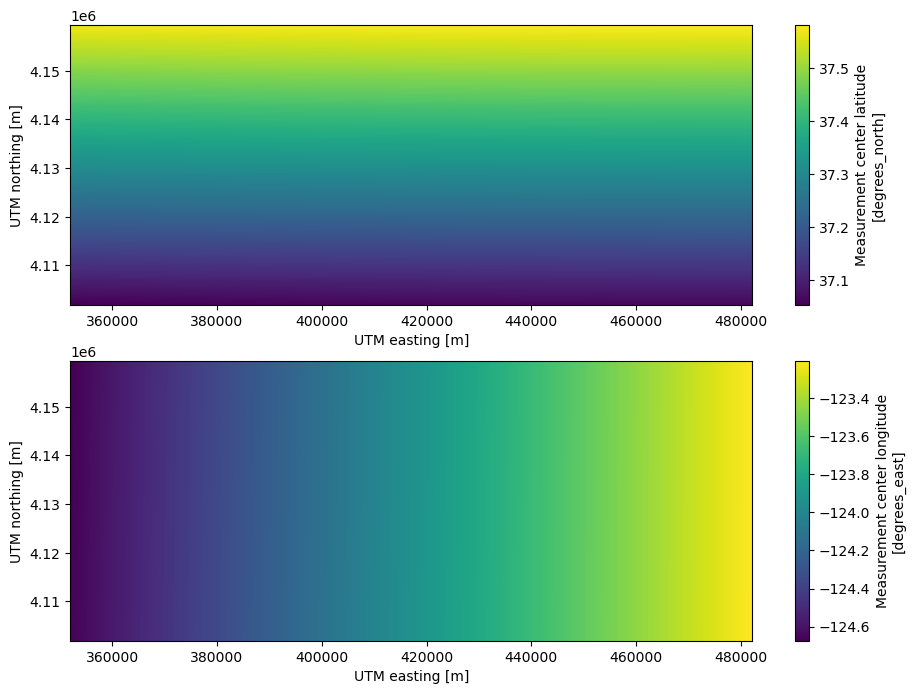

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(11, 8))
ds.latitude.plot(ax=ax[0])
ds.longitude.plot(ax=ax[1])

# Estimates using all of the observations

In [11]:
all_kwds = [kw for kw in ds if '_all_' in kw]
ds_all = ds[all_kwds].copy(deep=True)
all_kwds

['nobs_all_lines',
 'wind_speed_all_lines',
 'wind_speed_error_all_lines',
 'wind_dir_all_lines',
 'wind_dir_error_all_lines',
 'look_diff_all_lines',
 'azimuth_diversity_flag_all_lines',
 'u_current_all_lines',
 'v_current_all_lines',
 'u_current_error_all_lines',
 'v_current_error_all_lines']

In [12]:
phi = np.radians(ds_all['wind_dir_all_lines'])
ds_all['u_wind_all_lines'] = ds_all['wind_speed_all_lines']*np.sin(phi)
ds_all['v_wind_all_lines'] = ds_all['wind_speed_all_lines']*np.cos(phi)

## Apply the good data mask for all current observations

Only accept estimates that use a minimum number of observations. The current recommended number is 4. Use the variable `nobs_all_lines` to make a mask and then mask all variables 

In [13]:
def mask_velocity_all_lines(ds, minobs, data_vars, vthresh=0.1):
    """Mask all measurements with fewer than minobs observations."""
    bad = ( (ds.nobs_all_lines.data < minobs) |
           (ds.u_current_error_all_lines.data > vthresh) |
           (ds.v_current_error_all_lines.data > vthresh) )
    for v in data_vars:
        if np.issubdtype(ds[v].dtype, np.floating):
            ds[v].data[bad] = np.nan
    return ds

In [14]:
minobs = 4
vthresh =0.1
data_vars = [
    'u_current_all_lines',
    'v_current_all_lines',
    'u_current_error_all_lines',
    'v_current_error_all_lines']
ds_all = mask_velocity_all_lines(ds_all, minobs, data_vars, vthresh)

# Plot the current and wind fields

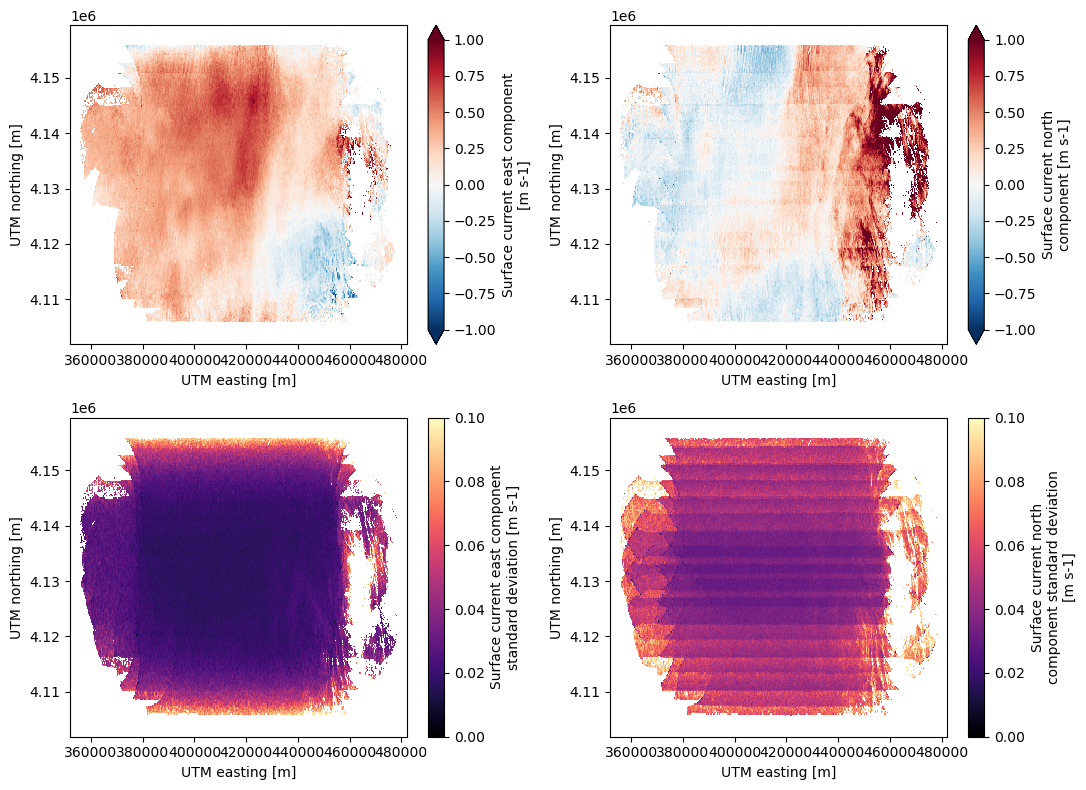

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(11, 8))

ds_all['u_current_all_lines'].plot(vmin=-1, vmax=1, cmap='RdBu_r', ax=ax[0,0])
ds_all['v_current_all_lines'].plot(vmin=-1, vmax=1, cmap='RdBu_r', ax=ax[0,1])
ds_all['u_current_error_all_lines'].plot(vmin=0, vmax=0.1, cmap='magma', ax=ax[1,0])
ds_all['v_current_error_all_lines'].plot(vmin=0, vmax=0.1, cmap='magma', ax=ax[1,1])
plt.tight_layout()

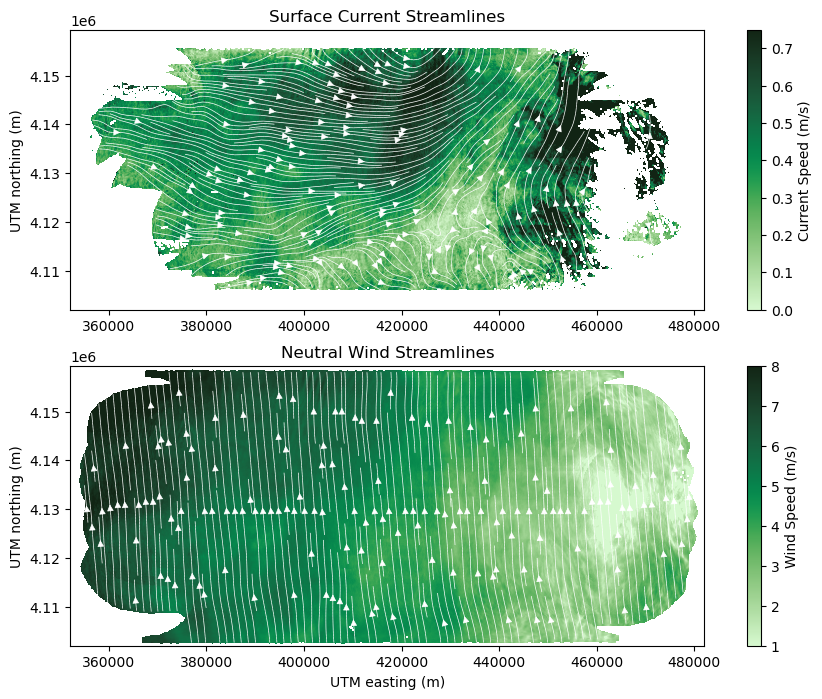

In [16]:
kwargs = dict(
    cmap='algae',
    fout=None,
    orientation='landscape',
    dpi=120,
    cbar=True,
    show_axes=True,
    grid=False,
    subsample=1,
    smooth_stddev=2,
    raster=True,
    streamlines=True,
    color='white',
    density=3,
    linewidth=0.5,
)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(11, 8))

cbar_kwds = {'label':'Current Speed (m/s)'}
vmin = 0.
vmax = 0.75
make_streamplot_image(
                    ds_all['u_current_all_lines'],
                    ds_all['v_current_all_lines'],
                    vmin,
                    vmax,
                    cbar_kwds=cbar_kwds,
                    fig=fig,
                    ax=ax[0],
                    **kwargs
)
ax[0].set_ylabel('UTM northing (m)')
ax[0].set_title('Surface Current Streamlines')

cbar_kwds = {'label':'Wind Speed (m/s)'}
vmin = 1.
vmax = 8.
make_streamplot_image(
                    ds_all['u_wind_all_lines'],
                    ds_all['v_wind_all_lines'],
                    vmin,
                    vmax,
                    cbar_kwds=cbar_kwds,
                    fig=fig,
                    ax=ax[1],
                    **kwargs
)

ax[1].set_xlabel('UTM easting (m)')
ax[1].set_ylabel('UTM northing (m)')
ax[1].set_title('Neutral Wind Streamlines');


# Look at the line data

Line data uses only a single flight line to get estimates of surface currents and winds. This minimizes the temporal aliasing, but maximizes the errors at the nadir and swath edges. This effect is most marked for the currents and not as important for the winds. Due to the smaller number of looks, the geographical coverage is limited.

In [17]:
[kw for kw in ds if ('_line' in kw) and ('_lines' not in kw)]

['wind_speed_line',
 'wind_speed_line_merged',
 'wind_speed_error_line',
 'wind_dir_line',
 'wind_dir_line_merged',
 'wind_dir_error_line',
 'winds_likely_corrupted_line',
 'look_diff_line',
 'azimuth_diversity_flag_line',
 'xt_bias_u_line',
 'xt_bias_v_line',
 'u_current_line',
 'v_current_line',
 'u_current_error_line']

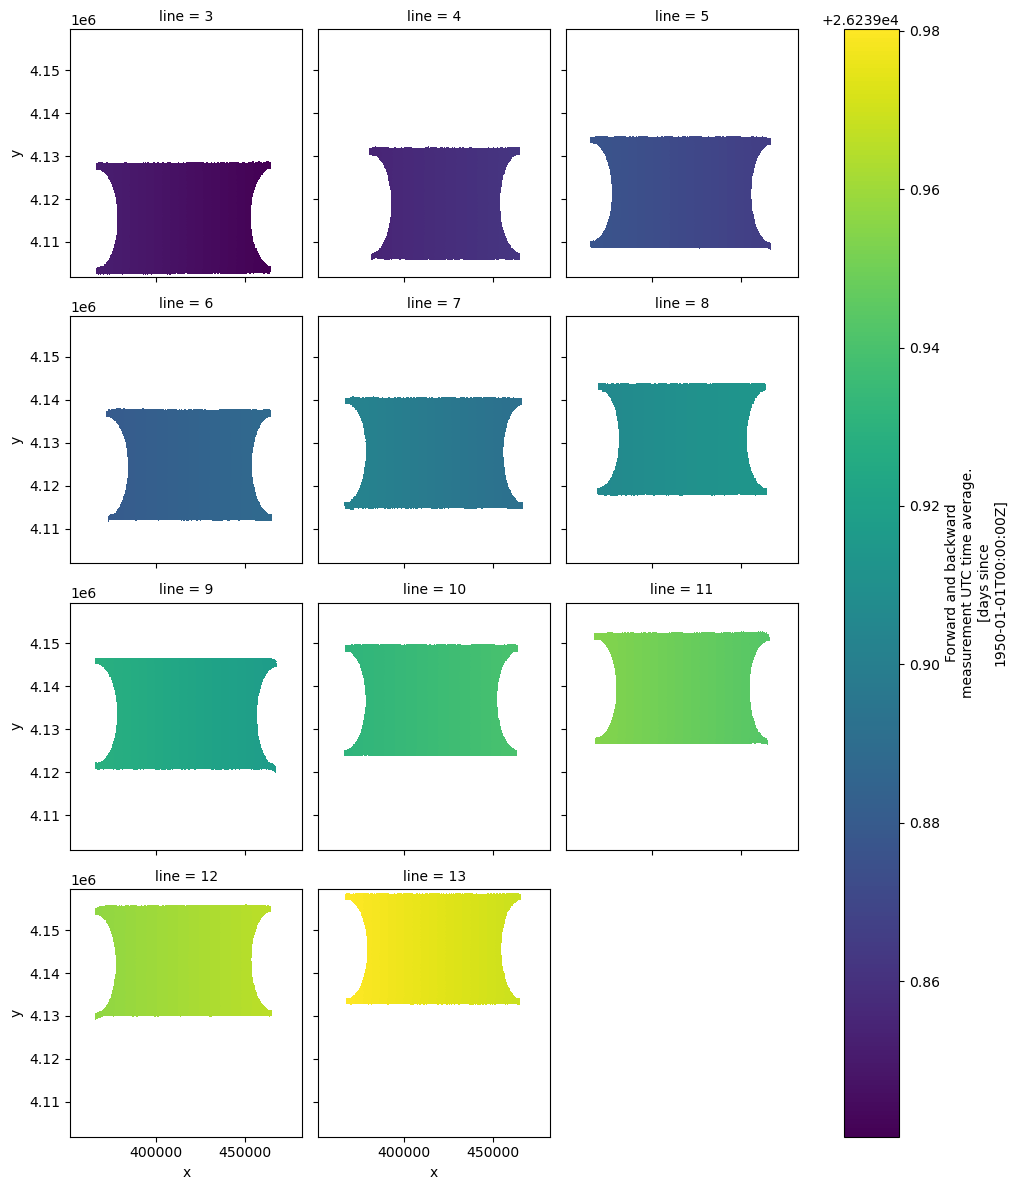

In [18]:
ds['mean_observation_time'].plot(x='x', y='y', col='line', col_wrap=3,
                           cmap='viridis');

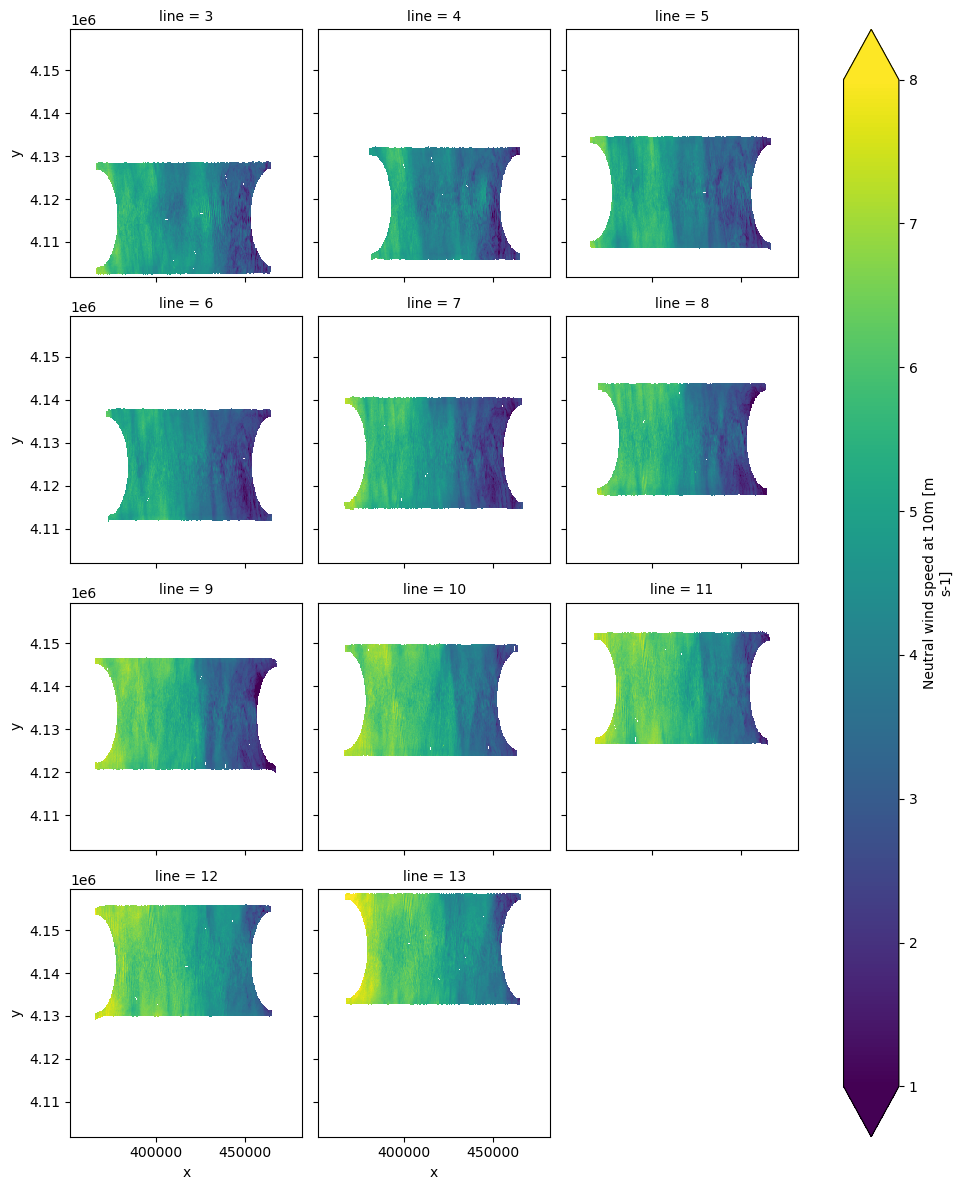

In [19]:
ds['wind_speed_line'].plot(x='x', y='y', col='line', col_wrap=3,
                           vmin=1, vmax=8, cmap='viridis');

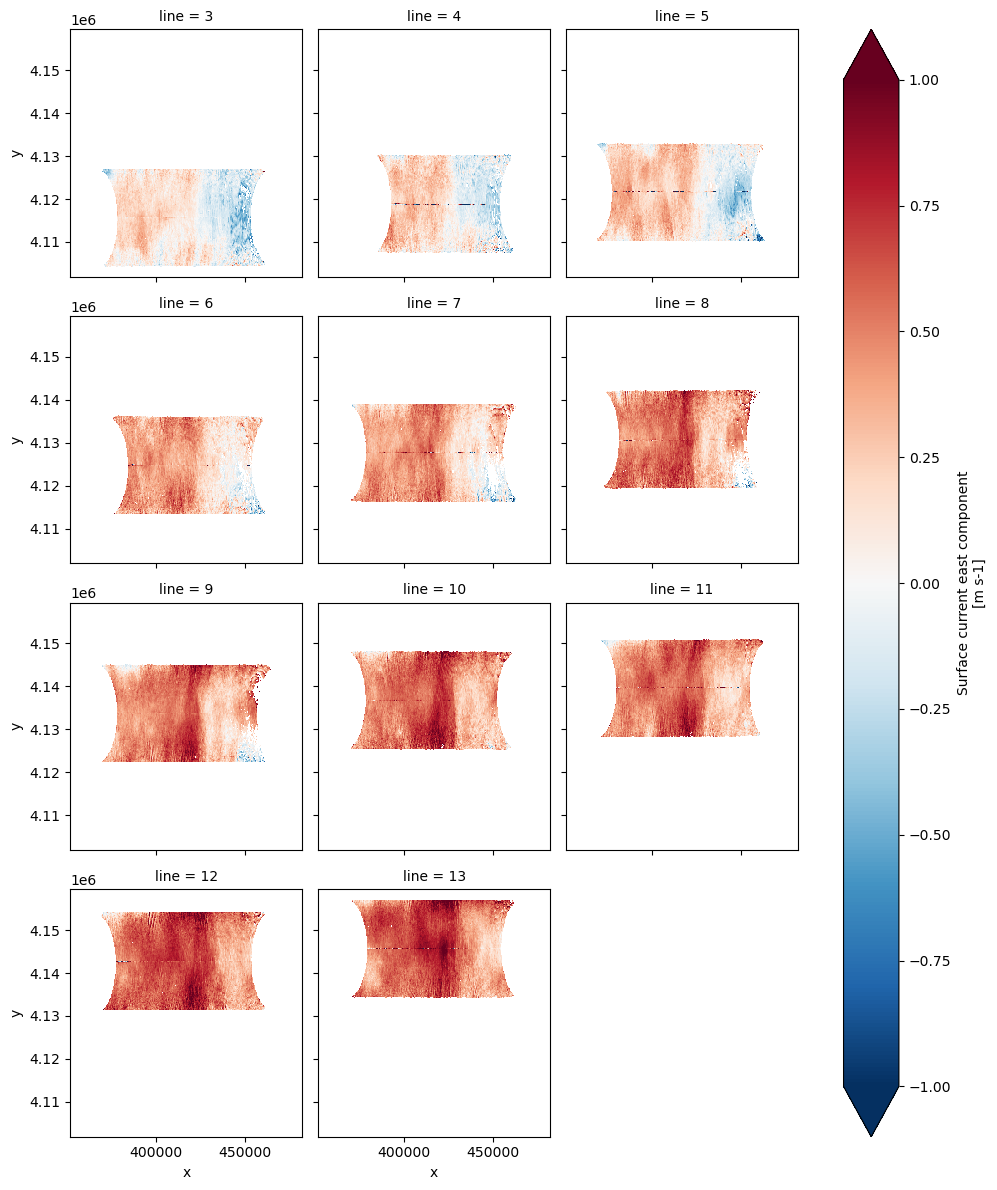

In [20]:
ds['u_current_line'].plot(x='x', y='y', col='line', col_wrap=3,
                           vmin=-1, vmax=1, cmap='RdBu_r');

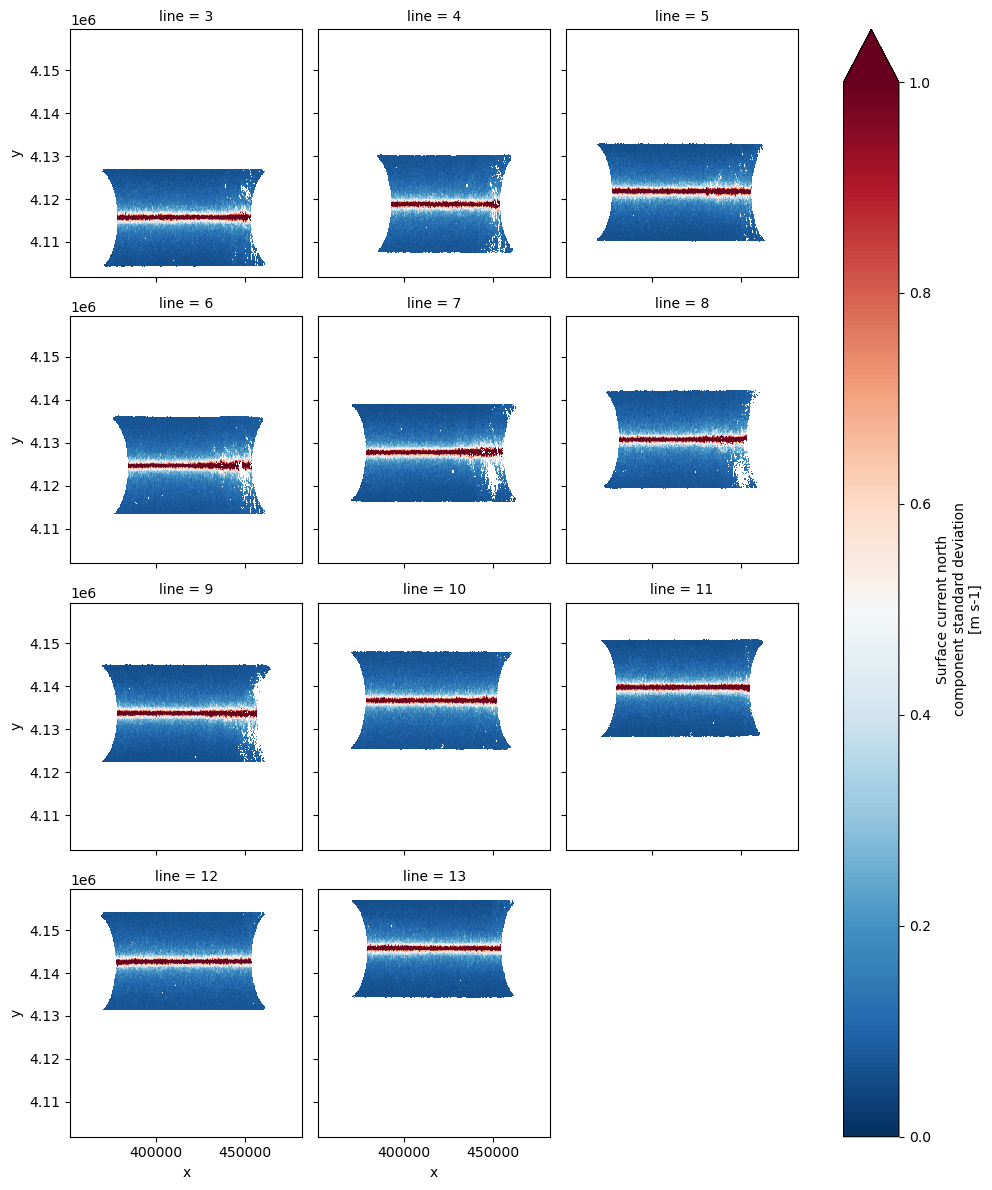

In [21]:
ds['u_current_error_line'].plot(x='x', y='y', col='line', col_wrap=3,
                           vmin=0, vmax=1, cmap='RdBu_r');

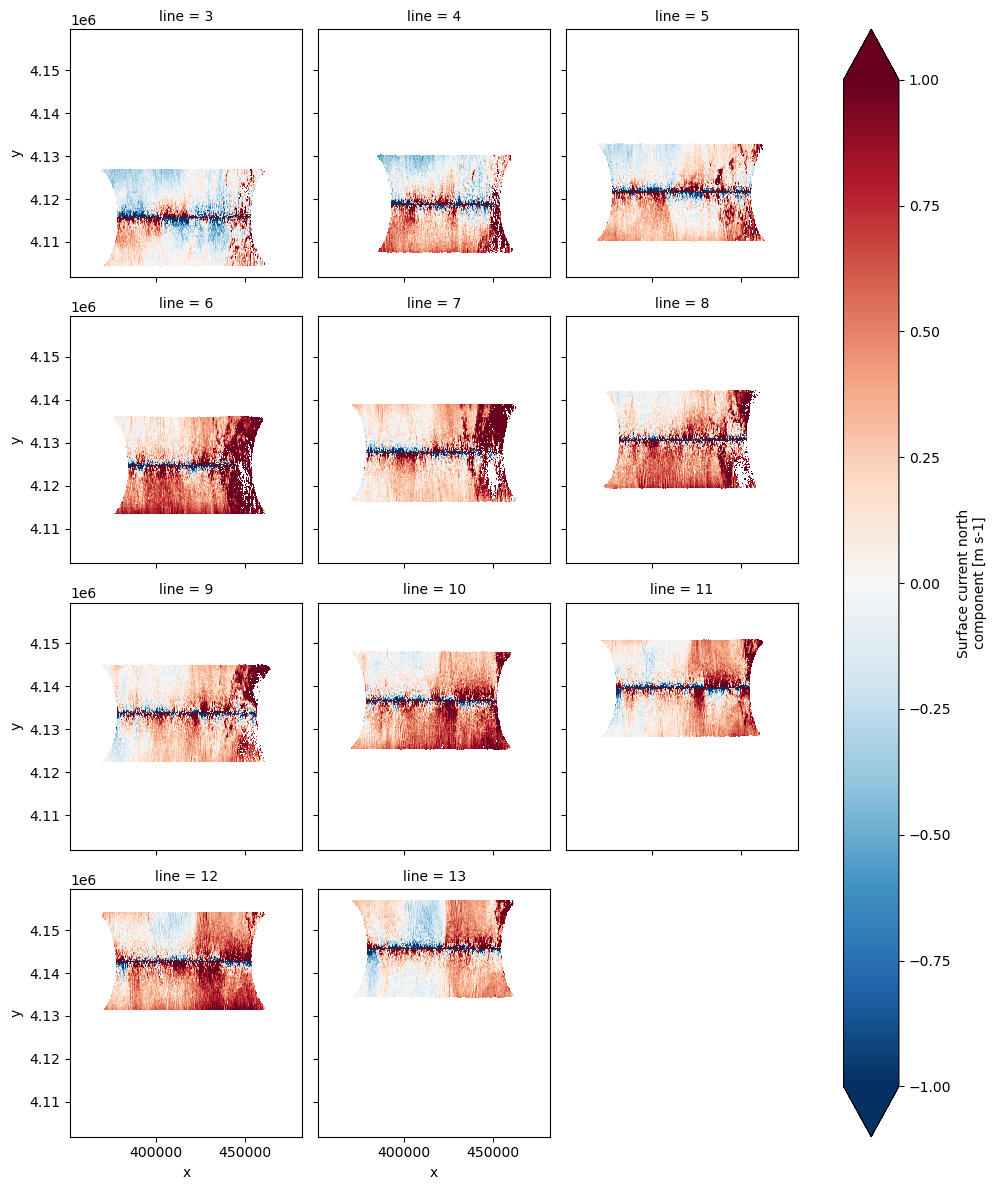

In [22]:
ds['v_current_line'].plot(x='x', y='y', col='line', col_wrap=3,
                           vmin=-1, vmax=1, cmap='RdBu_r');

**Note** The v-component velocity error seems to be missing from the PODAAC S-MODE V1 dataset.

It is instructive to compare the average over all lines with the estimates utilizing all of the data.

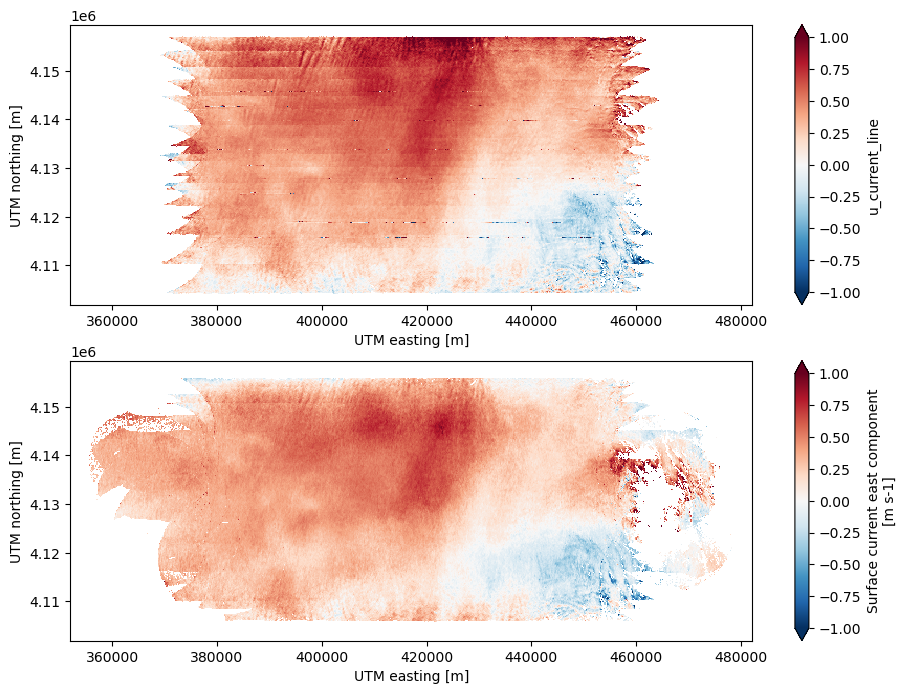

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(11, 8))
ds['u_current_line'].mean(dim='line').plot(vmin=-1,vmax=1,cmap='RdBu_r', ax=ax[0])
ds_all['u_current_all_lines'].plot(vmin=-1,vmax=1,cmap='RdBu_r', ax=ax[1])

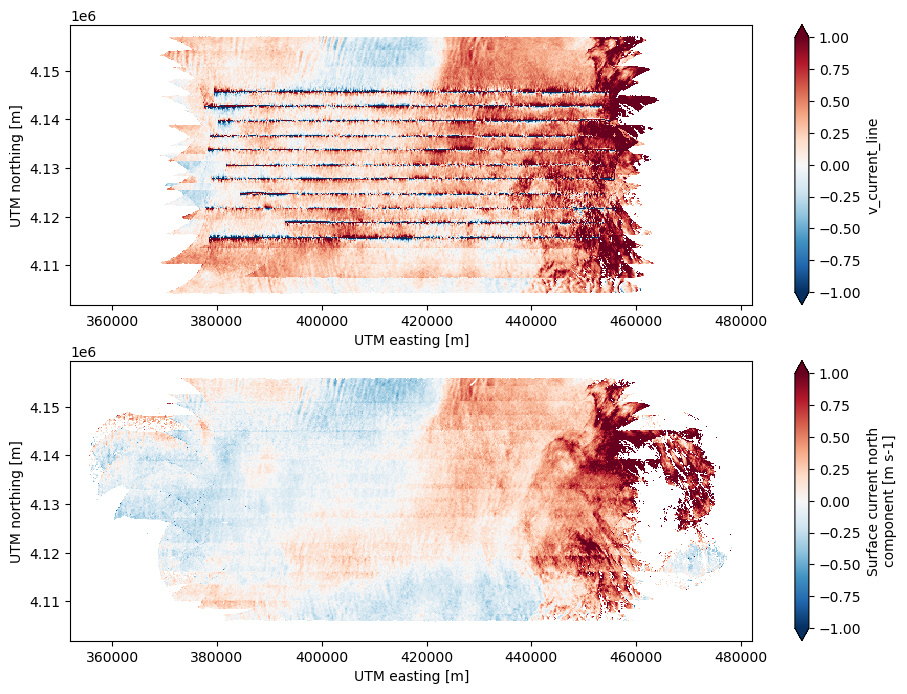

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(11, 8))
ds['v_current_line'].mean(dim='line').plot(vmin=-1,vmax=1,cmap='RdBu_r', ax=ax[0])
ds_all['v_current_all_lines'].plot(vmin=-1,vmax=1,cmap='RdBu_r', ax=ax[1])